# Web Scraping and Data Analysis & Visualization

In [1]:
# Importing required libraries
import pandas as pd
import requests
from requests import get
import re
import numpy as np
from time import time, sleep
from IPython.core.display import clear_output
from random import randint
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Scraping data for over 2000 movies from IMDB website

In [2]:
pages = [str(i) for i in range(1,5)]
years_url = [str(i) for i in range(2000,2018)]
headers = {"Accept-Language": "en-US, en;q=0.5"}

In [3]:
# Declaring the lists to store data in
names = []
years = []
imdb_ratings = []
metascores = []
votes = []

# Preparing the monitoring of the loop
start_time = time()
requests = 0

# For every year in the interval 2000-2017
for year_url in years_url:

    # For every page in the interval 1-4
    for page in pages:

        # Make a get request
        response = get('https://www.imdb.com/search/title?release_date=' + year_url +
        '&sort=num_votes,desc&page=' + page, headers = headers)

        # Pause the loop
        sleep(randint(8,15))

        # Monitor the requests
        requests += 1
        elapsed_time = time() - start_time
        print('Request:{}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))
        clear_output(wait = True)

        # Throw a warning for non-200 status codes
        if response.status_code != 200:
            warn('Request: {}; Status code: {}'.format(requests, response.status_code))

        # Break the loop if the number of requests is greater than expected
        if requests > 72:
            warn('Number of requests was greater than expected.')
            break

        # Parse the content of the request with BeautifulSoup
        page_html = BeautifulSoup(response.text, 'html.parser')

        # Select all the 50 movie containers from a single page
        mv_containers = page_html.find_all('div', class_ = 'lister-item mode-advanced')

        # For every movie of these 50
        for container in mv_containers:
            # If the movie has a Metascore, then:
            if container.find('div', class_ = 'ratings-metascore') is not None:

                # Scrape the name
                name = container.h3.a.text
                names.append(name)

                # Scrape the year
                year = container.h3.find('span', class_ = 'lister-item-year').text
                years.append(year)

                # Scrape the IMDB rating
                imdb = float(container.strong.text)
                imdb_ratings.append(imdb)

                # Scrape the Metascore
                m_score = container.find('span', class_ = 'metascore').text
                metascores.append(int(m_score))

                # Scrape the number of votes
                vote = container.find('span', attrs = {'name':'nv'})['data-value']
                votes.append(int(vote))

Request:72; Frequency: 0.06007852494308931 requests/s


## Storing the Scraped Data into a Pandas DataFrame

In [4]:
movie_ratings = pd.DataFrame({'movie': names,
'year': years,
'imdb': imdb_ratings,
'metascore': metascores,
'votes': votes
})
print(movie_ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3264 entries, 0 to 3263
Data columns (total 5 columns):
movie        3264 non-null object
year         3264 non-null object
imdb         3264 non-null float64
metascore    3264 non-null int64
votes        3264 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 127.6+ KB
None


In [5]:
movie_ratings.head(10)

,movie,year,imdb,metascore,votes
0,Gladiator,(2000),8.5,67,1359035
1,Memento,(2000),8.4,80,1139291
2,Snatch,(2000),8.3,55,790865
3,Requiem for a Dream,(2000),8.3,68,776547
4,X-Men,(2000),7.4,64,576129
5,Cast Away,(2000),7.8,73,532753
6,American Psycho,(2000),7.6,64,502281
7,Unbreakable,(2000),7.3,62,390696
8,Mission: Impossible II,(2000),6.1,59,317839
9,Meet the Parents,(2000),7.0,73,313610


# Cleaning the scraped data

We’ll clean the scraped data for: plotting the distribution of IMDB and Metascore ratings.<br>

### Step I: Reordering the columns

In [6]:
movie_ratings = movie_ratings[['movie', 'year', 'imdb', 'metascore', 'votes']]
movie_ratings.head()

,movie,year,imdb,metascore,votes
0,Gladiator,(2000),8.5,67,1359035
1,Memento,(2000),8.4,80,1139291
2,Snatch,(2000),8.3,55,790865
3,Requiem for a Dream,(2000),8.3,68,776547
4,X-Men,(2000),7.4,64,576129


### Step II: Cleaning the year column and convert the values to integers

Right now all the values are of the object type. To avoid ValueErrors upon conversion, we want the values to be composed only from numbers from 0 to 9.
Let’s examine the unique values of the year column. This helps us to get an idea of what we could do to make the conversions we want. 

In [7]:
movie_ratings['year'].unique()

array(['(2000)', '(I) (2000)', '(2001)', '(2002)', '(2003)', '(2004)',
       '(I) (2004)', '(2005)', '(I) (2005)', '(2006)', '(I) (2006)',
       '(2007)', '(I) (2007)', '(2008)', '(I) (2008)', '(2009)',
       '(I) (2009)', '(2010)', '(I) (2010)', '(2011)', '(I) (2011)',
       '(2012)', '(I) (2012)', '(2013)', '(I) (2013)', '(2014)',
       '(I) (2014)', '(II) (2014)', '(2015)', '(I) (2015)', '(II) (2015)',
       '(2016)', '(II) (2016)', '(IX) (2016)', '(I) (2016)', '(2017)',
       '(I) (2017)'], dtype=object)

In [8]:
# converting the year values to integers 
movie_ratings.loc[:, 'year'] = movie_ratings['year'].str[-5:-1].astype(int)
movie_ratings['year'].head(3)

0    2000
1    2000
2    2000
Name: year, dtype: int32

### Step III: Checking the extreme rating values to determine if all the ratings are within the expected intervals

In [9]:
movie_ratings.describe().loc[['min', 'max'], ['imdb', 'metascore']]

,imdb,metascore
min,4.1,24.0
max,9.0,100.0


There are no unexpected outliers.<br>
From the values above, we can see that the two ratings have different scales.<br>
To be able to plot the two distributions on a single graph, we’ll have to bring them to the same scale.

### Step IV: Normalizing one of the ratings type (or both) for generating a comparative histogram.

In [10]:
# normalizing the imdb column to a 100-points scale by multiplying each IMDB rating by 10
movie_ratings['n_imdb'] = movie_ratings['imdb'] * 10
movie_ratings.head(3)

,movie,year,imdb,metascore,votes,n_imdb
0,Gladiator,2000,8.5,67,1359035,85.0
1,Memento,2000,8.4,80,1139291,84.0
2,Snatch,2000,8.3,55,790865,83.0


# Plotting and analyzing the distributions

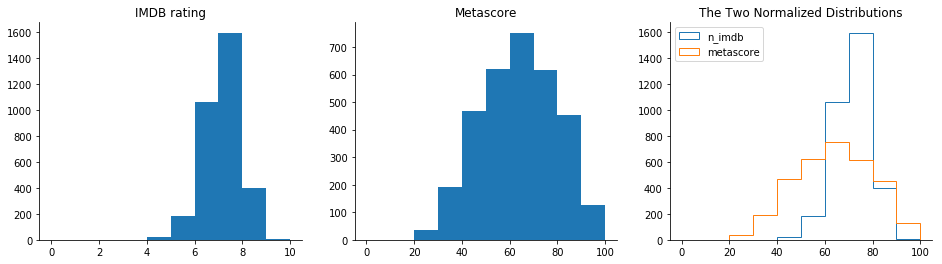

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16,4))
ax1, ax2, ax3 = fig.axes
ax1.hist(movie_ratings['imdb'], bins = 10, range = (0,10)) # bin range = 1
ax1.set_title('IMDB rating')
ax2.hist(movie_ratings['metascore'], bins = 10, range = (0,100)) # bin range = 10
ax2.set_title('Metascore')
ax3.hist(movie_ratings['n_imdb'], bins = 10, range = (0,100), histtype = 'step')
ax3.hist(movie_ratings['metascore'], bins = 10, range = (0,100), histtype = 'step')
ax3.legend(loc = 'upper left')
ax3.set_title('The Two Normalized Distributions')
for ax in fig.axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.show()

## Conclusion -
Starting with the IMDB histogram, we can see that most ratings are between 6 and 8. There are few movies with a rating greater than 8, and even fewer with a rating smaller than 4. This indicates that both very good movies and very bad movies are rarer.<br>

The distribution of Metascore ratings resembles a normal distribution – most ratings are average, peaking at the value of approximately 50. From this peak, the frequencies gradually decrease toward extreme rating values. According to this distribution, there are indeed fewer very good and very bad movies, but not that few as the IMDB ratings indicate.<br>

On the comparative graph, it’s clearer that the IMDB distribution is highly skewed toward the higher part of the average ratings, while the Metascore ratings seem to have a much more balanced distribution.<br>

What might be the reason for that skew in the IMDB distribution? One hypothesis is that many users tend to have a binary method of assessing movies. If they like the movie, they give it a 10. If they don’t like the movie, they give it a very small rating, or they don’t bother to rate the movie.